In [82]:
# + проверить выкидывание групп
# + сначала разбить, потом обработать
# + catboost

# neuron

# reg 2 classification


import gc

gc.enable()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

import lightgbm as lgb

import os
import os.path
# print(os.listdir("../input"))

# credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

In [83]:
by_team = ['matchId','groupId']

In [84]:
random_seed = 15305
df_train = None

if not os.path.isfile('train_V2_solo.csv'):
    print('Solo file not exists, load all')
    df_train = pd.read_csv('train_V2.csv')
    df_train = reduce_mem_usage(df_train)
    df_train = df_train[df_train['winPlacePerc'].isna() != True]
    mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
    
#     df_train['matchType'].value_counts().plot.bar()
    
    df_train['matchType'] = df_train['matchType'].apply(mapper)
    
    old_size = df_train.shape[0]
    
    df_train = df_train[df_train['matchType'] == 'solo']
    
    print('Reduced size from ', old_size, ' to ', df_train.shape[0])
    
    df_train.to_csv('train_V2_solo.csv', index=False)
    
else:
    df_train = pd.read_csv('train_V2_solo.csv')
    df_train = reduce_mem_usage(df_train)
    print('Solo file exists, loaded, size: ', df_train.shape[0])
        

gc.collect()

Solo file exists, loaded, size:  720712


7

In [85]:
df_train.describe(include=np.number).drop('count').T

,mean,std,min,25%,50%,75%,max
assists,0.062236,0.297540,0.0,0.000000,0.000000,0.000000,22.0
boosts,1.059862,1.799456,0.0,0.000000,0.000000,2.000000,28.0
damageDealt,NaN,NaN,0.0,0.000000,74.375000,169.250000,6616.0
DBNOs,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
headshotKills,0.249281,0.660425,0.0,0.000000,0.000000,0.000000,42.0
heals,1.014149,2.406086,0.0,0.000000,0.000000,1.000000,63.0
killPlace,47.457529,27.728956,1.0,23.000000,47.000000,71.000000,100.0
killPoints,447.426431,594.989089,0.0,0.000000,0.000000,1090.000000,1970.0
kills,0.936860,1.603249,0.0,0.000000,0.000000,1.000000,66.0
killStreaks,0.475054,0.564241,0.0,0.000000,0.000000,1.000000,18.0


In [185]:
# none of null, inf columns
null_columns=df_train.columns[df_train.isin([np.Inf, np.NINF, np.nan]).any()]
df_train[null_columns].isnull().sum()

Series([], dtype: float64)

In [87]:
df_train.drop('DBNOs',  axis =1,inplace= True)
df_train.drop('revives',  axis =1,inplace= True)

Index([], dtype='object')

In [88]:
df_train['maxPlace'].describe()

count    720712.000000
mean         93.908900
std          10.134818
min           2.000000
25%          94.000000
50%          96.000000
75%          97.000000
max         100.000000
Name: maxPlace, dtype: float64

In [89]:

def feature_engineering(df, is_train=True):
    test_idx = None
    if not is_train: 
        print("processing test")
        test_idx = df.Id
    else:
        print("processing train")
#         Попробовал, точность упала, не нравится // model_train_out_group_size.txt
#         отвергнуто 
# 
#         print('Len before deleting ', df.shape[0])
#         agg = df.groupby(by_team).size().reset_index(name='group_size')
#         print('Group size > 1:', agg[agg['group_size'] > 1].shape[0])
#         df = df.merge(agg, how='left', on=by_team)
#         df = df[df['group_size'] <= 1]
    
#         df.drop('group_size',  axis =1,inplace= True)
        
#         print('Len after deleting ', df.shape[0])
    

    
    print("remove some columns")
    target = 'winPlacePerc'

    print("Adding Features")
    
#     Гиптеза о +1 при делении ухудшила результат lightgbm, у catboost незначительное улучшение
#    отвергнуто
# 
    
    df['headshotrate'] = df['kills']/ (df['headshotKills'] )
    df['killStreakrate'] = df['killStreaks']/ (df['kills'] )
    df['healthitems'] = df['heals'] + df['boosts']
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    df['killPlace_over_maxPlace'] = df['killPlace'] / (df['maxPlace'] )
    df['headshotKills_over_kills'] = df['headshotKills'] / (df['kills'] )
    df['distance_over_weapons'] = df['totalDistance'] / (df['weaponsAcquired'] )
    df['walkDistance_over_heals'] = df['walkDistance'] / (df['heals'] )
    df['walkDistance_over_kills'] = df['walkDistance'] / (df['kills'] )
    df['killsPerWalkDistance'] = df['kills'] / (df['walkDistance'] )
    df['skill'] = df['headshotKills'] + df['roadKills']
    
    df['totalTimeByDistance'] = df['rideDistance'] / float(5) + df['walkDistance'] + df['swimDistance'] * float(5)
    
    df['zombi'] = ((df['totalDistance'] == 0) & (df['kills'] == 0)
                     & (df['weaponsAcquired'] == 0)).astype(int)
    df['cheater'] = ((df['kills'] / df['totalDistance'] >= 1)
                       | (df['kills'] > 30) | (df['roadKills'] > 10)).astype(int)

    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    
    print("Removing Na's From DF")
    df.fillna(0, inplace=True)

    
    features = list(df.columns)
    features.remove("Id")

    features.remove(target)
    features.remove("matchId")
    
    features.remove("groupId")
    features.remove("matchType")
    
    
    
    return df[features], df[target], features, test_idx
    

In [90]:
# X, y, columns, _ = feature_engineering(df_train, True)
# X = reduce_mem_usage(X)

In [91]:
import random

# ухудшает, потому что этим надо разбивать изначально,а не только обучение

def train_test_split_match(df, test_size=0.1):
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1 - test_size))
    train_match_ids = random.sample(match_ids, train_size)

    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]
    
    train_y = train['winPlacePerc']
    test_y = test['winPlacePerc']
    
    train.drop(['matchId','winPlacePerc'] ,  axis =1,inplace= True)
    test.drop(['matchId','winPlacePerc'] ,  axis =1,inplace= True)
    
    return train, test, train_y, test_y

In [92]:
# X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.1,
# random_state=random_seed)

import warnings
warnings.filterwarnings("ignore")

X_train, X_holdout, y_train, y_holdout = train_test_split(df_train, df_train['winPlacePerc'], test_size=0.1,
random_state=random_seed)


X_train, y_train, columns, _ = feature_engineering(X_train, True)
X_train = reduce_mem_usage(X_train)


X_holdout, _, _ ,_ = feature_engineering(X_holdout, False)

train_index = round(int(X_train.shape[0]*0.9))
dev_X = X_train[:train_index] 
val_X = X_train[train_index:]
dev_y = y_train[:train_index] 
val_y = y_train[train_index:] 
gc.collect()

gc.collect()
print(dev_X.shape, val_X.shape)

processing train
remove some columns
Adding Features
Removing Na's From DF
processing test
remove some columns
Adding Features
Removing Na's From DF
(583776, 36) (64864, 36)


In [93]:
print(X_train.shape, X_holdout.shape)

(648640, 36) (72072, 36)


In [145]:



model_name = '0.9_3000_model_best.txt'

def run_lgb(train_X, train_y, val_X, val_y, x_test):
    params = {"objective" : "regression", "metric" : "mae", 'n_estimators':30000,#20000,
              'early_stopping_rounds':300,
              "num_leaves" : 31, "learning_rate" : 0.05, 
              "bagging_fraction" : 0.9,#0.7,
               "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.9#0.7
             }
    model = None
    
    if not os.path.isfile(model_name):
        print(model_name, ' not found, start train ;-(')
        lgtrain = lgb.Dataset(train_X, label=train_y)
        lgval = lgb.Dataset(val_X, label=val_y)
        model = lgb.train(params, lgtrain, valid_sets=[lgtrain, lgval], verbose_eval=1000)
        model.save_model(model_name)
        
    else:
        print(model_name, ' found, start predict ;-)')
        model = lgb.Booster(model_file=model_name)
        
    
    pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)
    return pred_test_y, model

# Training the model #
pred_test, model = run_lgb(dev_X, dev_y, val_X, val_y, X_holdout)
gc.collect()

0.9_3000_model_best.txt  not found, start train ;-(
Training until validation scores don't improve for 300 rounds.
[1000]	training's l1: 0.0392495	valid_1's l1: 0.0400309
[2000]	training's l1: 0.0379732	valid_1's l1: 0.0395566
[3000]	training's l1: 0.0370108	valid_1's l1: 0.0393062
[4000]	training's l1: 0.0361541	valid_1's l1: 0.0390877
[5000]	training's l1: 0.0353952	valid_1's l1: 0.0389398
[6000]	training's l1: 0.0346687	valid_1's l1: 0.0387954
[7000]	training's l1: 0.0340049	valid_1's l1: 0.0386875
[8000]	training's l1: 0.0333475	valid_1's l1: 0.0385775
[9000]	training's l1: 0.0327632	valid_1's l1: 0.0385085
[10000]	training's l1: 0.0321685	valid_1's l1: 0.0384066
[11000]	training's l1: 0.0315975	valid_1's l1: 0.0383315
[12000]	training's l1: 0.0310792	valid_1's l1: 0.0382797
[13000]	training's l1: 0.030581	valid_1's l1: 0.0382428
[14000]	training's l1: 0.0301125	valid_1's l1: 0.0382096
[15000]	training's l1: 0.0296214	valid_1's l1: 0.0381403
[16000]	training's l1: 0.0291558	valid_1

1366

In [148]:
pred_y = pred_test.copy()
df_sub = X_holdout.copy()
gc.collect()
df_sub.head()

,assists,boosts,damageDealt,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,...,killPlace_over_maxPlace,headshotKills_over_kills,distance_over_weapons,walkDistance_over_heals,walkDistance_over_kills,killsPerWalkDistance,skill,totalTimeByDistance,zombi,cheater
252538,0,0,0.00,0,0,96,1670,0,0,0.00000,...,1.000000,0.0,0.000,0.0,0.0,0.000000,0,0.0,1,0
443955,0,0,0.00,0,4,57,0,0,0,0.00000,...,1.055556,0.0,0.000,0.0,0.0,0.000000,0,0.0,0,0
134536,0,1,0.00,0,0,58,0,0,0,0.00000,...,0.604167,0.0,308.000,0.0,0.0,0.000000,0,1088.0,0,0
663320,0,5,205.75,0,3,13,0,2,1,304.25000,...,0.134021,0.0,888.000,1480.0,2220.0,0.000450,0,4440.0,0,0
56745,0,0,100.00,0,0,33,0,1,1,5.84375,...,0.354839,0.0,82.375,0.0,329.5,0.003035,0,329.5,0,0


In [149]:
print("MAE: ",
mean_absolute_error(y_holdout, pred_y) )

print("MSE: ",
mean_squared_error(y_holdout, pred_y))

MAE:  0.038204562611468304
MSE:  0.0033404532355836075


MAE:  0.03835205551321234
MSE:  0.0033308355521584616

MAE:  0.039442003815586504<br>
MSE:  0.0034430096325873847<br>
<br>

MAE:  0.04354560510495446<br>
MSE:  0.00416523884441271<br>
<br>
MAE:  0.3085248959709384 <br>
MSE:  0.1272983096471534

In [150]:
def fix_pred(X, pred):
    df_sub = X.copy()
    df_sub['winPlacePerc'] = pred
    df_sub.loc[df_sub.maxPlace == 0, "winPlacePerc"] = 0
    df_sub.loc[df_sub.maxPlace == 1, "winPlacePerc"] = 1.0
    df_sub.loc[(df_sub['maxPlace'] > 1) & (df_sub['numGroups'] == 1), 'winPlacePerc'] = 0
    subset = df_sub.loc[df_sub.maxPlace > 1]
    gap = 1.0 / (subset.maxPlace.values - 1)
    new_perc = np.around(subset.winPlacePerc.values / gap) * gap
    df_sub.loc[df_sub.maxPlace > 1, "winPlacePerc"] = new_perc
    
#     df_sub.loc[df_sub["winPlacePerc"] < 0, "winPlacePerc"] = 0
#     df_sub.loc[df_sub["winPlacePerc"] > 1, "winPlacePerc"] = 1.0
    
    
    return df_sub["winPlacePerc"]

light_fix_pred = fix_pred(df_sub, pred_test)

print("MAE: ",
mean_absolute_error(y_holdout, light_fix_pred) )

print("MSE: ",
mean_squared_error(y_holdout, light_fix_pred))

MAE:  0.03794351563520207
MSE:  0.003343428900863441


In [152]:
fi = model.feature_importance(importance_type='gain')
fn = model.feature_name()
fi = fi / fi.max() * 100

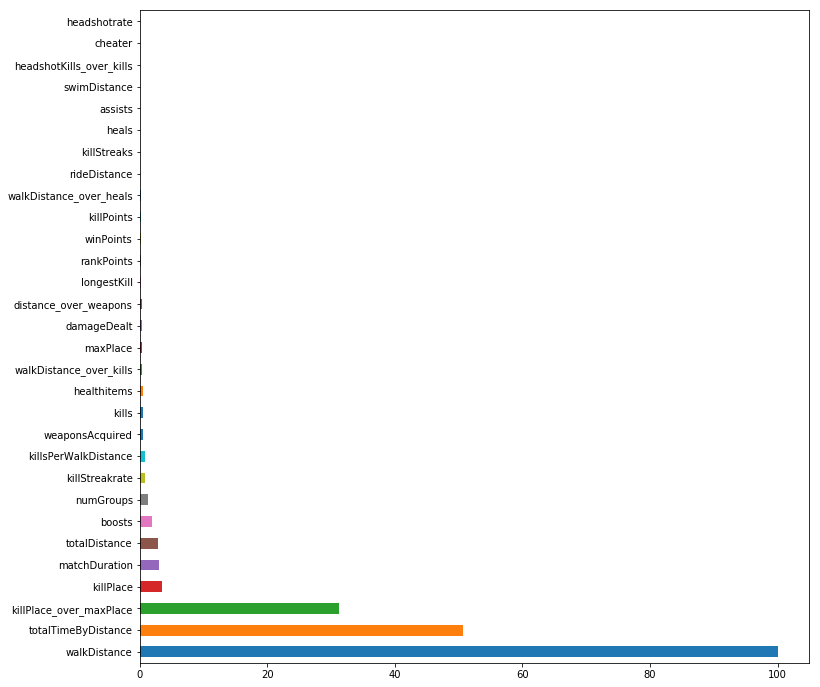

In [153]:
feat_importances = pd.Series(fi, index=fn)
feat_importances.nlargest(30).plot(kind='barh', figsize=(12,12))

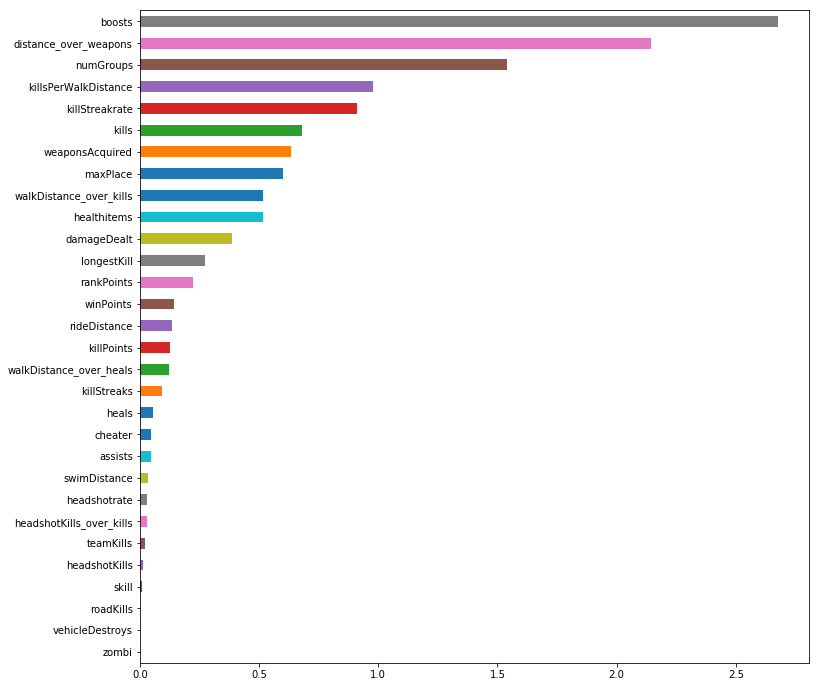

In [59]:
feat_importances.nsmallest(30).plot(kind='barh', figsize=(12,12))

# Test CatBoost

In [95]:
import catboost
from catboost import CatBoostRegressor

cat_model_name = 'new_cat_model.txt'
def run_catboost(X_train, y_train, X_val, y_val, X_test):
    model = None
    
    
    
    if not os.path.isfile(cat_model_name):
        print(cat_model_name, ' not found, start train ;-(')
        model = CatBoostRegressor(iterations=2500,#1500,
                             learning_rate=0.05,
                             depth=13,
                             eval_metric='MAE',
                              
                             bootstrap_type='Bayesian',
                             bagging_temperature = 0.4,
                             colsample_bylevel=0.9,

                             od_type='Iter',

                             od_wait=20)
        model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True,
              verbose=False)
        model.save_model(cat_model_name)
        
    else:
        print(cat_model_name, ' found, start predict ;-)')
        model = CatBoostRegressor()
        model.load_model(cat_model_name)
    
    
    
    
    y_pred_submit = model.predict(X_test)

    return y_pred_submit, model

In [96]:
cat_preds, cat_model = run_catboost(dev_X, dev_y, val_X, val_y, X_holdout)
gc.collect()


cat_iters_2500  not found, start train ;-(


21

In [98]:
print("MAE: ",
mean_absolute_error(y_holdout, cat_preds) )

print("MSE: ",
mean_squared_error(y_holdout, cat_preds))

print("MAE: ",
mean_absolute_error(y_holdout, fix_pred(df_sub,cat_preds)) )

MAE:  0.03930947714587424
MSE:  0.003449869912570009
MAE:  0.039098391076763314


In [ ]:
MAE:  0.03930947714587424
MSE:  0.003449869912570009
    
MAE:  0.03935530079373704
MSE:  0.003452247054532898
    
MAE:  0.03937937994147074
MSE:  0.003442165049903201
    
MAE:  0.03985730187929903
MSE:  0.0035289553600514898
    
MAE:  0.039967249401811435
MSE:  0.0035292414797628764
    
MAE:  0.040002110668519705
MSE:  0.0035109118428077045
    
MAE:  0.04018625081067348
MSE:  0.0035448821657998275

In [64]:
cat_fi = cat_model.get_feature_importance(fstr_type='FeatureImportance')
cat_fn = cat_model.feature_names_
cat_fi = cat_fi


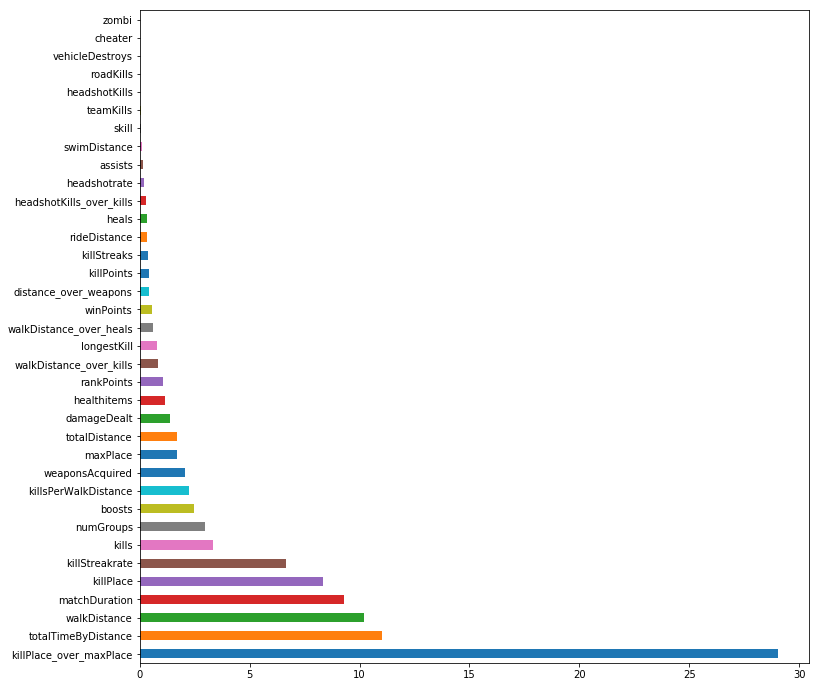

In [65]:
cat_feat_importances = pd.Series(cat_fi, index=cat_fn)
cat_feat_importances.nlargest(50).plot(kind='barh', figsize=(12,12))

# Random forest
<!--https://www.kaggle.com/pavelvpster/pubg-random-forest-baseline !-->

In [14]:
from sklearn.ensemble import RandomForestRegressor
# X_train, X_holdout, y_train, y_holdout 
rf = RandomForestRegressor(n_estimators=3000, criterion='mse',max_depth=6,
                           min_samples_leaf=3, max_features='sqrt',
                           n_jobs=-1, verbose=True)
rf.fit(X_train, y_train)

In [14]:
rf_y_pred = rf.predict(X_holdout)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 11.8min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed:    3.

In [28]:
print("MAE: ",
mean_absolute_error(y_holdout, rf_y_pred) )

print("MSE: ",
mean_squared_error(y_holdout, rf_y_pred))

MAE:  0.06138763809018693
MSE:  0.007488019050449579


MAE:  0.06138763809018693 <br>
MSE:  0.007488019050449579 <br>
неплохо, но lightgbm лучше

In [66]:
rf_fi = rf.feature_importances_
rf_fn = X_train.columns

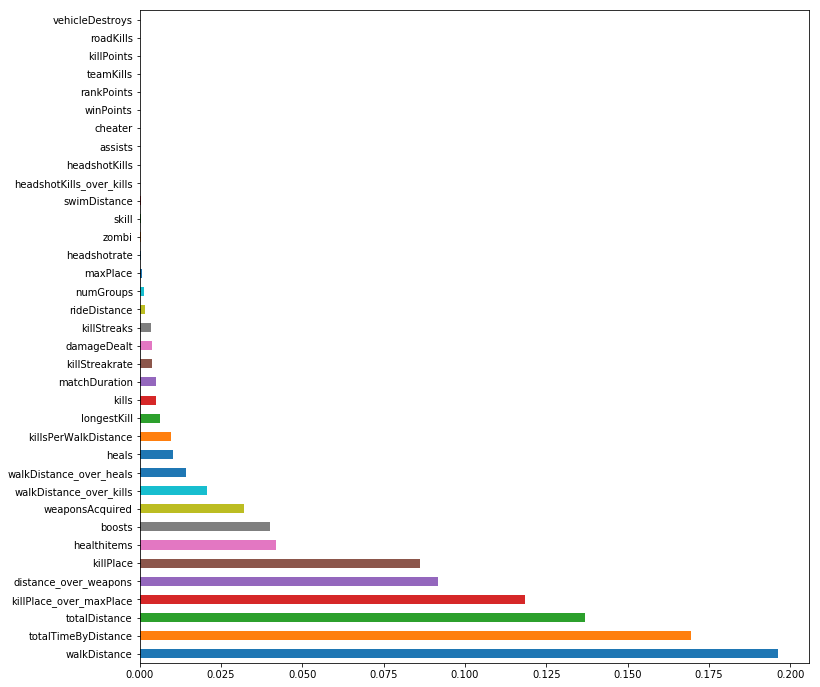

In [154]:
rf_feat_importances = pd.Series(rf_fi, index=rf_fn)
rf_feat_importances.nlargest(50).plot(kind='barh', figsize=(12,12))

# xgboost

In [16]:
import xgboost

In [112]:
xgb = xgboost.XGBRegressor(
    n_estimators=1650, max_depth=11,
    disable_default_eval_metric=1,
    
    subsample=0.9,
    colsample_bytree=0.9,
    learning_rate=0.05#0.007
    )
xgb.fit(dev_X, dev_y,
        eval_set=[(val_X, val_y)], eval_metric='mae',
        early_stopping_rounds=100)

[0]	validation_0-mae:0.246332
Will train until validation_0-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:0.234549
[2]	validation_0-mae:0.223388
[3]	validation_0-mae:0.212937
[4]	validation_0-mae:0.202963
[5]	validation_0-mae:0.193455
[6]	validation_0-mae:0.184447
[7]	validation_0-mae:0.175927
[8]	validation_0-mae:0.167856
[9]	validation_0-mae:0.160209
[10]	validation_0-mae:0.152988
[11]	validation_0-mae:0.146207
[12]	validation_0-mae:0.139787
[13]	validation_0-mae:0.133692
[14]	validation_0-mae:0.127916
[15]	validation_0-mae:0.122479
[16]	validation_0-mae:0.117346
[17]	validation_0-mae:0.112514
[18]	validation_0-mae:0.107974
[19]	validation_0-mae:0.103693
[20]	validation_0-mae:0.099702
[21]	validation_0-mae:0.095935
[22]	validation_0-mae:0.092372
[23]	validation_0-mae:0.089021
[24]	validation_0-mae:0.085888
[25]	validation_0-mae:0.082946
[26]	validation_0-mae:0.080166
[27]	validation_0-mae:0.077575
[28]	validation_0-mae:0.075161
[29]	validation_0-mae:0.072877
[30]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, disable_default_eval_metric=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=1650, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9)

In [113]:
xgb_y_pred = xgb.predict(X_holdout)

In [137]:
print("MAE: ",
mean_absolute_error(y_holdout, xgb_y_pred) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_y_pred))


print("MAE: ",
mean_absolute_error(y_holdout, fix_pred(df_sub, xgb_y_pred)) )

MAE:  0.03787041
MSE:  0.0033754273
MAE:  0.037610762662964786


In [99]:
MAE:  0.03984858
MSE:  0.0035125967
MAE:  0.03963832653640412

In [99]:
# from sklearn.model_selection import GridSearchCV

In [102]:
# params_grid_xgb = {
#           'reg_alpha': [0, 0.5],
#           'reg_lambda': [0, 0.5],
#           'gamma': [0, 0.5],
#           'subsample': [0.7, 1],
#           'colsample_bytree':[0.7, 1],
#           'max_depth': [1] +[1 + i*2 for i in range(3,6)],
#           'learning_rate': [0.05],
#           'n_estimators': [1000 + 500*i for i in range(1,3)]
# }
# xgb_grid = GridSearchCV(xgb, param_grid=params_grid_xgb, cv=5, n_jobs=-1,
# verbose=True)
# print(params_grid_xgb)

{'reg_alpha': [0, 0.5], 'reg_lambda': [0, 0.5], 'gamma': [0, 0.5], 'subsample': [0.7, 1], 'colsample_bytree': [0.7, 1], 'max_depth': [1, 7, 9, 11], 'learning_rate': [0.05], 'n_estimators': [1500, 2000]}


In [ ]:
# xgb_grid.fit(X_train, y_train)
# print("Fit end")
# print(xgb_grid.best_params_, xgb_grid.best_score_)

In [115]:
xgb.save_model('xgb_037')

MAE:  0.03984858 <br>
MSE:  0.0035125967 <br>
на уровне с lightgbm

In [155]:
xgb_fi = xgb.feature_importances_
xgb_fn = X_train.columns

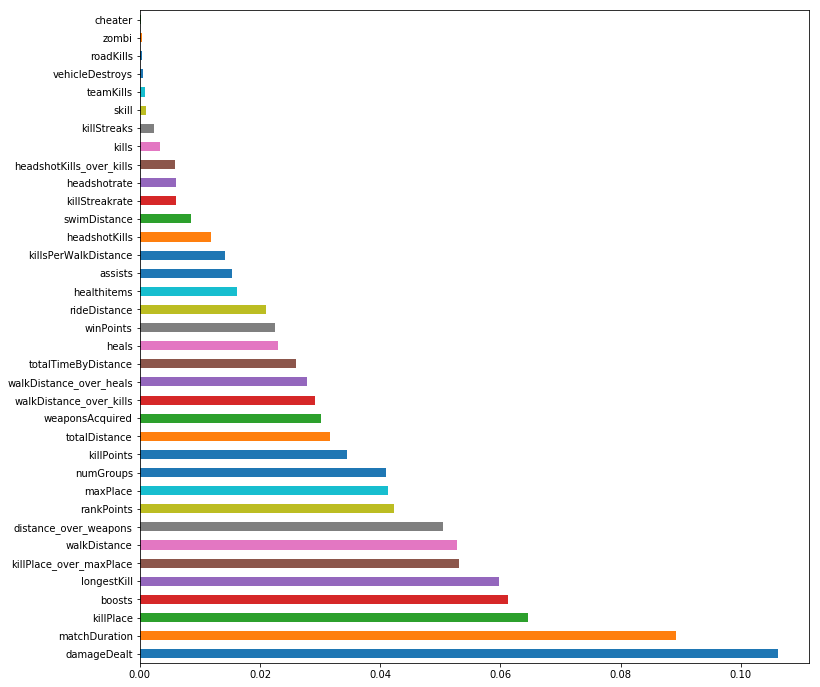

In [156]:
xgb_feat_importances = pd.Series(xgb_fi, index=xgb_fn)
xgb_feat_importances.nlargest(50).plot(kind='barh', figsize=(12,12))

In [157]:
xgb_cat_light = (xgb_y_pred + cat_preds + pred_y) / float(3)
print("MAE: ",
mean_absolute_error(y_holdout, xgb_cat_light) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_cat_light))

MAE:  0.03797528697856334
MSE:  0.0032927908276403914


In [158]:
xgb_cat_light_rf = (0.1*xgb_y_pred + 0.05*cat_preds + 0.8*pred_y + 0.05*rf_y_pred) 
xgb_cat_light_rf = fix_pred(df_sub, xgb_cat_light_rf)
print("MAE: ",
mean_absolute_error(y_holdout, xgb_cat_light_rf) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_cat_light_rf))



MAE:  0.03797135476325532
MSE:  0.0033159750784003505


In [160]:
import itertools
all_pred = [fix_pred(df_sub, xgb_y_pred) , fix_pred(df_sub, cat_preds) ,
            fix_pred(df_sub,pred_y), fix_pred(df_sub,rf_y_pred)]

all_names = ['xgb', 'cat', 'light', 'rf']

perms = [x for l in range(1, len(all_pred)) for x in itertools.combinations(all_pred, l)]

perms_names = [x for l in range(1, len(all_names)) for x in itertools.combinations(all_names, l)]

best_mae = 99
best_comb = ''
for p, p_name in zip(perms, perms_names):
    pred = sum(p) / len(p)
    
    pred = fix_pred(df_sub,pred)
    
    pred[pred > 1] = 1.0
    pred[pred < 0] = 0.0
    
    mae = mean_absolute_error(y_holdout, pred)
    print("MAE: ",
     mae)
    if mae < best_mae:
        best_mae = mae
        best_comb = p_name
        

    print("MSE: ",
    mean_squared_error(y_holdout, pred))
    print('next')
    
print("Best MAE: ",
     best_mae)
print(best_comb)

MAE:  0.03761076264123822
MSE:  0.003363435679381474
next
MAE:  0.03904907316679887
MSE:  0.0034574501924131977
next
MAE:  0.037849318934970407
MSE:  0.00333096965477936
next
MAE:  0.06105763426800979
MSE:  0.00744968323596438
next
MAE:  0.03805896841703159
MSE:  0.003346524399073411
next
MAE:  0.037479118888566344
MSE:  0.0032973446144523764
next
MAE:  0.04582930048114942
MSE:  0.0043768412715880275
next
MAE:  0.038177995113180326
MSE:  0.00334360935553123
next
MAE:  0.046614265109462566
MSE:  0.004482858995409761
next
MAE:  0.04580486843010441
MSE:  0.004355349179902291
next
MAE:  0.03772598449933292
MSE:  0.003297650707003935
next
MAE:  0.04242450448247116
MSE:  0.003836323016419464
next
MAE:  0.041913057069501464
MSE:  0.0037711279205819986
next
MAE:  0.04244958436666296
MSE:  0.003827683012778285
next
Best MAE:  0.037479118888566344
('xgb', 'light')


In [134]:
0.03757936481538985

0.03757936481538985

In [181]:
xgb_cat_light_rf = (0.55*fix_pred(df_sub,xgb_y_pred) +  0.45*fix_pred(df_sub,pred_y)) 
xgb_cat_light_rf = fix_pred(df_sub, xgb_cat_light_rf)

xgb_cat_light_rf[xgb_cat_light_rf > 1] = 1.0
xgb_cat_light_rf[xgb_cat_light_rf < 0] = 0.0

print("MAE: ",
mean_absolute_error(y_holdout, xgb_cat_light_rf) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_cat_light_rf))



MAE:  0.03736932502041915
MSE:  0.0032889180378494966


In [ ]:
MAE:  0.03736932502041915
MSE:  0.0032889180378494966
    

In [ ]:
best = 1.0
best_mae = 11
for i in range(5400, 5600):
    part = 0.0001 * i
    pred = (part*fix_pred(df_sub,xgb_y_pred) +  (1 - part)*fix_pred(df_sub,pred_y)) 
    
    pred = fix_pred(df_sub,pred)
    
    pred[pred > 1] = 1.0
    pred[pred < 0] = 0.0
#     print(part)
    
    mae = mean_absolute_error(y_holdout, pred)
    if mae < best_mae:
        best_mae = mae
        best = part
print(best_mae, best)

# XGB Stack

In [186]:
X_train_stack = X_train.copy()
X_train_stack['xgb_pred'] = xgb.predict(X_train)

In [187]:
X_train_stack['rf_pred'] = rf.predict(X_train)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:   25.8s
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:   35.1s
[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed:   43.9s finished


In [188]:
X_train_stack['ligth_gbm_pred'] = model.predict(X_train, num_iteration=model.best_iteration)

In [189]:
X_train_stack['cat_pred'] = cat_model.predict(X_train)

In [ ]:
# dev_X = X_train[:train_index] 
# val_X = X_train[train_index:]
# dev_y = y_train[:train_index] 
# val_y = y_train[train_index:] 
# gc.collect()

In [191]:
xgb_stack = xgboost.XGBRegressor(
    n_estimators=1650, max_depth=11,
    
    subsample=0.9,
    colsample_bytree=0.9,
    learning_rate=0.05#0.007
    )
xgb_stack.fit(X_train_stack, y_train)
# xgb.save_model('xgb_stack')

In [192]:
xgb_stack.save_model('xgb_stack')

In [193]:
xgb_stack.save_model('xgb_stack')

In [196]:
X_holdout_stack = X_holdout.copy()

X_holdout_stack['xgb_pred'] = xgb.predict(X_holdout)
X_holdout_stack['rf_pred'] = rf.predict(X_holdout)
X_holdout_stack['ligth_gbm_pred'] = model.predict(X_holdout, num_iteration=model.best_iteration)
X_holdout_stack['cat_pred'] = cat_model.predict(X_holdout)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed:    4.6s finished


In [198]:
xgb_stack_y_pred = xgb_stack.predict(X_holdout_stack)


In [199]:
print("MAE: ",
mean_absolute_error(y_holdout, xgb_stack_y_pred) )

print("MSE: ",
mean_squared_error(y_holdout, xgb_stack_y_pred))


print("MAE: ",
mean_absolute_error(y_holdout, fix_pred(df_sub, xgb_stack_y_pred)) )

MAE:  0.037927605
MSE:  0.0035110812
MAE:  0.03770065111732159


In [200]:
xgb_stack_y_pred_fixed = xgb_stack_y_pred.copy()
xgb_stack_y_pred_fixed[xgb_stack_y_pred_fixed > 1] = 1.0
xgb_stack_y_pred_fixed[xgb_stack_y_pred_fixed < 0] = 0.0

print("MAE: ",
mean_absolute_error(y_holdout, fix_pred(df_sub, xgb_stack_y_pred_fixed)) )

MAE:  0.037696032767860786


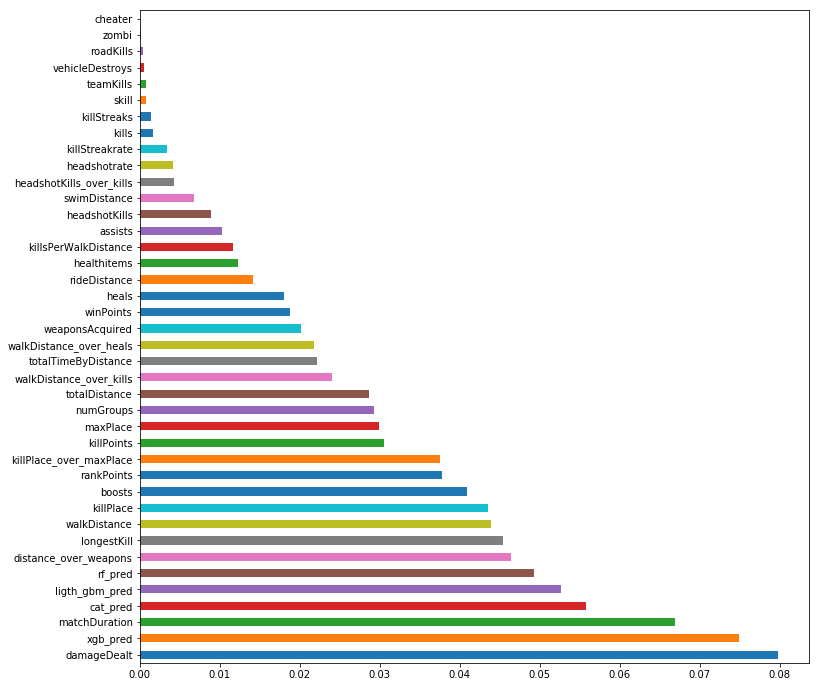

In [201]:
xgb_stack_fi = xgb_stack.feature_importances_
xgb_stack_fn = X_holdout_stack.columns

xgb_stack_feat_importances = pd.Series(xgb_stack_fi, index=xgb_stack_fn)
xgb_stack_feat_importances.nlargest(50).plot(kind='barh', figsize=(12,12))

# RF Stack

In [202]:
rf_stack = RandomForestRegressor(n_estimators=3000, criterion='mse',max_depth=6,
                           min_samples_leaf=3, max_features='sqrt',
                           n_jobs=-1, verbose=True)
rf_stack.fit(X_train_stack, y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 21.5min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=True,
           warm_start=False)

In [207]:
rf_stack_y_pred = rf_stack.predict(X_holdout_stack)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed:    4.4s finished


In [208]:
print("MAE: ",
mean_absolute_error(y_holdout, rf_stack_y_pred) )

print("MSE: ",
mean_squared_error(y_holdout, rf_stack_y_pred))


print("MAE: ",
mean_absolute_error(y_holdout, fix_pred(df_sub, rf_stack_y_pred)) )

MAE:  0.040093599188525814
MSE:  0.0034933602460376512
MAE:  0.0397767326689902


In [209]:
rf_stack_y_pred_fixed = rf_stack_y_pred.copy()
rf_stack_y_pred_fixed[rf_stack_y_pred_fixed > 1] = 1.0
rf_stack_y_pred_fixed[rf_stack_y_pred_fixed < 0] = 0.0

print("MAE: ",
mean_absolute_error(y_holdout, fix_pred(df_sub, rf_stack_y_pred_fixed)) )

MAE:  0.0397767326689902


# Light GBM

In [211]:
params_lgb_stack = {"objective" : "regression", "metric" : "mae", 'n_estimators':30000,#20000,
              'early_stopping_rounds':300,
              "num_leaves" : 31, "learning_rate" : 0.05, 
              "bagging_fraction" : 0.9,#0.7,
               "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.9#0.7
             }


lgtrain = lgb.Dataset(X_train_stack, label=y_train)

lgb_stack = lgb.train(params_lgb_stack, lgtrain, valid_sets=[lgtrain], verbose_eval=1000)
lgb_stack.save_model('light_gbm_stack')

Training until validation scores don't improve for 300 rounds.
[1000]	training's l1: 0.018572
[2000]	training's l1: 0.0179996
[3000]	training's l1: 0.0175499
[4000]	training's l1: 0.0171627
[5000]	training's l1: 0.0168179
[6000]	training's l1: 0.0165004
[7000]	training's l1: 0.0161982
[8000]	training's l1: 0.0159154
[9000]	training's l1: 0.0156475
[10000]	training's l1: 0.0153908
[11000]	training's l1: 0.0151478
[12000]	training's l1: 0.014916
[13000]	training's l1: 0.014689
[14000]	training's l1: 0.0144714
[15000]	training's l1: 0.0142606
[16000]	training's l1: 0.0140552
[17000]	training's l1: 0.0138611
[18000]	training's l1: 0.013671
[19000]	training's l1: 0.013486
[20000]	training's l1: 0.0133022
[21000]	training's l1: 0.0131252
[22000]	training's l1: 0.0129538
[23000]	training's l1: 0.012788
[24000]	training's l1: 0.012626
[25000]	training's l1: 0.0124685
[26000]	training's l1: 0.0123141
[27000]	training's l1: 0.0121628
[28000]	training's l1: 0.0120139
[29000]	training's l1: 0.0118

In [212]:
lgb_stack_pred_y = lgb_stack.predict(X_holdout_stack, num_iteration=lgb_stack.best_iteration)

In [213]:
print("MAE: ",
mean_absolute_error(y_holdout, lgb_stack_pred_y) )

print("MSE: ",
mean_squared_error(y_holdout, lgb_stack_pred_y))


print("MAE: ",
mean_absolute_error(y_holdout, fix_pred(df_sub, lgb_stack_pred_y)) )

MAE:  0.03779731528870908
MSE:  0.003485739910326619
MAE:  0.03757619674037605


In [214]:
lgb_stack_y_pred_fixed = lgb_stack_pred_y.copy()
lgb_stack_y_pred_fixed[lgb_stack_y_pred_fixed > 1] = 1.0
lgb_stack_y_pred_fixed[lgb_stack_y_pred_fixed < 0] = 0.0

print("MAE: ",
mean_absolute_error(y_holdout, fix_pred(df_sub, lgb_stack_y_pred_fixed)) )

MAE:  0.03757031026031423
